Following [that notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html)

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import cv2


%matplotlib inline

In [2]:
import torch
import torch.nn as nn
#torch functional
import torch.nn.functional as F
import torch.nn.functional as functional
import torchvision
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)

cpu


In [3]:
original_transform = transforms.Compose([
    transforms.ToTensor()
])


contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),  
    transforms.RandomRotation(degrees=45), 
])

In [4]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=original_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

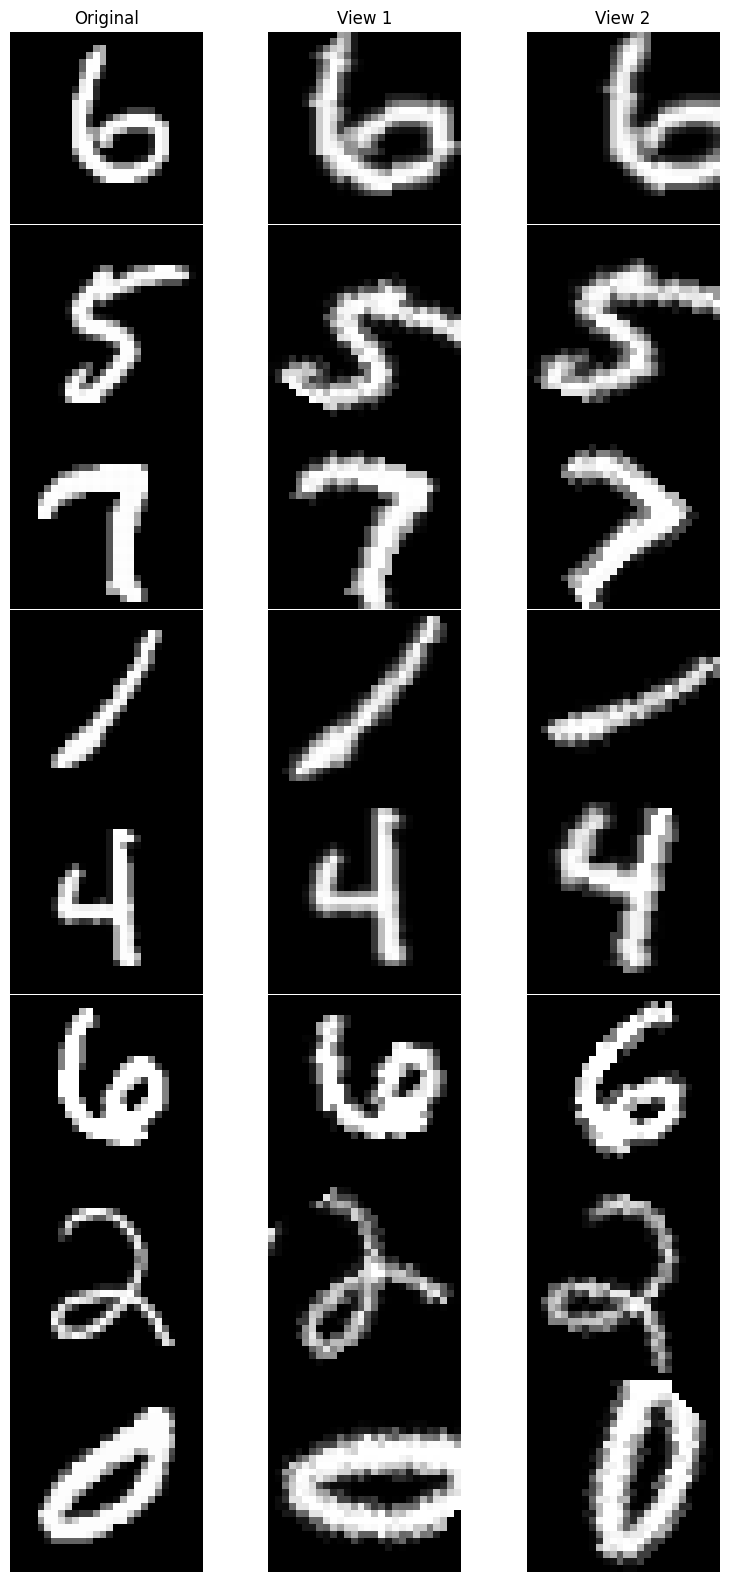

In [5]:
#plot 6 examples of original images + 2 augmented versions
batch, _ = next(iter(dataloader))

fig, axs = plt.subplots(8, 3, figsize=(10, 20))


for i in range(8):
    original = batch[i]
    axs[i, 0].imshow(original[0].numpy(), cmap='gray')
    if i==0:
        axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    for j in range(1, 3):
        augmented = contrast_transforms(original)
        axs[i, j].imshow(augmented[0].numpy(), cmap='gray')
        axs[i, j].axis('off')
        if i==0:
            axs[i, j].set_title('View {}'.format(j))

#remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [6]:
class EncoderCNN(nn.Module):

    def __init__(self, image_channels=1):
        super(EncoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 3, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 6, kernel_size=2, stride=3),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)


class ProjectionNN(nn.Module):

    def __init__(self, input_size=24, output_size=9):
        super(ProjectionNN, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.embedding(x)
   

class SimCLR(nn.Module):

    def __init__(self):
        super(SimCLR, self).__init__()

        self.encoder = EncoderCNN()
        self.projection = ProjectionNN()

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x
    


In [7]:
class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature
        self.similarity_f = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, zis, zjs):
        batch_size = zis.size(0)

        # Normalize the embeddings
        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        # Compute similarity
        representations = torch.cat([zis, zjs], dim=0)
        similarity_matrix = self.similarity_f(representations.unsqueeze(1), representations.unsqueeze(0))

        # Create the labels
        labels = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        # Mask to remove positive samples from the similarity matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # Apply temperature
        similarity_matrix = similarity_matrix / self.temperature

        # Create target labels
        target = torch.arange(batch_size).to(labels.device)

        loss_i = self.criterion(similarity_matrix[:batch_size], target)
        loss_j = self.criterion(similarity_matrix[batch_size:], target)

        loss = (loss_i + loss_j) / 2
        return loss


In [8]:
# %%
# Define training parameters
epochs = 10
temperature = 0.5
batch_size = 128
learning_rate = 1e-3


# Define model, criterion, and optimizer
model = SimCLR().to(device)
criterion = SimCLRLoss(temperature=temperature).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Load dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=original_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)




In [9]:

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for (orig_images, _) in tqdm(dataloader):
        view1 = contrast_transforms(orig_images)
        view2 = contrast_transforms(orig_images)
        batch_size_curr = view1.size(0)

        images = torch.cat([view1, view2], dim=0).to(device)

        zis = model(images[:batch_size_curr])
        zjs = model(images[batch_size_curr:])

        # Compute loss
        loss = criterion(zis, zjs)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')


100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


Epoch [1/5], Loss: 5.517730498364739


100%|██████████| 469/469 [00:17<00:00, 27.26it/s]


Epoch [2/5], Loss: 5.477951458522251


100%|██████████| 469/469 [00:17<00:00, 26.83it/s]


Epoch [3/5], Loss: 5.46814112368423


100%|██████████| 469/469 [00:19<00:00, 24.53it/s]


Epoch [4/5], Loss: 5.454212866866512


100%|██████████| 469/469 [00:17<00:00, 27.57it/s]

Epoch [5/5], Loss: 5.437553700607722


In [10]:
# Define the classifier network
class ClassifierNN(nn.Module):
    def __init__(self, input_size=24, num_classes=10):
        super(ClassifierNN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

class DownstreamModel(nn.Module):
    def __init__(self, encoder, classifier):
        super(DownstreamModel, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.classifier(x)
        return x



# Load pre-trained encoder from SimCLR
pretrained_encoder = model.encoder

# Freeze encoder weights
for param in pretrained_encoder.parameters():
    param.requires_grad = False

# Initialize classifier network
classifier = ClassifierNN()

# Create downstream classification model
downstream_model = DownstreamModel(pretrained_encoder, classifier).to(device)

# Define loss and optimizer for downstream task
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(downstream_model.classifier.parameters(), lr=learning_rate)

# Load dataset for supervised training
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=original_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=original_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop for the classifier
epochs = 10

for epoch in range(epochs):
    downstream_model.train()
    total_loss = 0

    for (images, labels) in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Evaluation on test dataset
downstream_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = downstream_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


100%|██████████| 469/469 [00:06<00:00, 74.34it/s]


Epoch [1/5], Loss: 1.6328


100%|██████████| 469/469 [00:06<00:00, 71.13it/s]


Epoch [2/5], Loss: 1.1751


100%|██████████| 469/469 [00:06<00:00, 69.16it/s]


Epoch [3/5], Loss: 1.0952


100%|██████████| 469/469 [00:06<00:00, 69.92it/s]


Epoch [4/5], Loss: 1.0537


100%|██████████| 469/469 [00:06<00:00, 69.58it/s]


Epoch [5/5], Loss: 1.0254
Test Accuracy: 65.40%


-----